In [50]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

import sys

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm

import datetime
from dateutil.parser import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from transformers import dayName, dummy_days, DFStandardScaler, DFFeatureUnion, ZeroFillTransformer

# 0. PREPROCESSING

## 0.1 Auxiliary functions and lists

### 0.1.1 One Hot Encoding

The function _**ohe**_ takes dataframe and encodes column (actually index) _'date'_ into 7 columns _Day names_ with binary input.

In [59]:
def ohe(self):
    self['day_of_week'] = self.index.get_level_values('date').day_name()
    encoded_columns = pd.get_dummies(self['day_of_week'])
    self = self.join(encoded_columns)
    self = self.drop('day_of_week',axis=1)
    return self

### 0.1.2 Scaling

Before calling the following function we have to provide separate dataframes for train and test data _and_ state the name of the column we want to scale. The function differs test from training data and after the scaler is fitted to train data, it transformes both training and test data. <br> <br> **Later:** improve function so it could 
* take only one dataframe as an argument 
* separate data to test and train data
* store that information 
* finally scale columns like it's described

In [9]:
def scaling_columns_seperately(self_train,self_test,col):
    aux_df = self_train[col]
    std_scaler.fit(aux_df.values.reshape(-1,1))
    aux_df = std_scaler.transform(self_train[col].values.reshape(-1,1))
    self_train[col] = aux_df
    
    aux_df = self_test[col]
    aux_df = std_scaler.transform(self_test[col].values.reshape(-1,1))
    self_test[col] = aux_df

<br>Scaling through each column for an _item_ in a for loop. <br> **Note:** self_train and self_test dataframes have same columns.<br> <br>**Later:** improve the loop (make function) so it could iterate over items (28, ..., 57) --> data is taken from df  **X**.

### 0.1.3 Handling outliers

-- outliers could be removed or set to a specific value (capping, flooring)<br> -- firstly we will _**remove**_ them

In [8]:
def removing_outliers(self):
    upper_lim = self['amount'].quantile(.95)
    lower_lim = self['amount'].quantile(.05)
    self=self[(self['amount'] < upper_lim) & (self['amount'] > lower_lim)]
    return self

### 0.1.4 Separating training and test data

In [6]:
def y_train_test_separation(self):
    aux = self.loc[self.index.get_level_values('date') <= '2018-01-01']
    train = aux['amount']
    
    aux = self.loc[self.index.get_level_values('date') > '2018-01-01']
    test = aux['amount']
    
    return train, test

In [7]:
def X_train_test_separation(self):
    aux = self.loc[self.index.get_level_values('date') <= '2018-01-01']
    train = aux.drop('amount',axis=1)
    
    aux = self.loc[self.index.get_level_values('date') > '2018-01-01']
    test = aux.drop('amount',axis=1)
    
    return train, test

### 0.1.5 Function and list initialization

In [12]:
std_scaler = StandardScaler()
lm = linear_model.LinearRegression()

In [13]:
list_of_items = [38,39,40,41,57] 

In [14]:
rmse_train = []
rmse_test = []
r2 = []

In [15]:
categorical_features = ['day_of_week']
numerical_features = ['regular_price', 'discounted_price','number_of_stores']

## 0.2 Pipeline

Process:
   * separate dependent array _"amount"_ and _the rest of dataframe_ from the initial dataframe
   * separate data into train and test set
   * fit model on train set
   * transform both train and test set

In [56]:
pipeline = Pipeline([ ('features', DFFeatureUnion([  ('categoricals', Pipeline([ ('dani',dayName()), ('dummyD', dummy_days())])),      
                                                   #('numerics', Pipeline([ ('zero_fill', ZeroFillTransformer()), ('log', Log1pTransformer()) ]))
                                                  ])), 
                      ('scaler', DFStandardScaler()) 
                   ])

## 0.3 Data loading

In [89]:
X = pd.read_parquet("C:/Users/vvrhovec/Veronika/kodovi/radni_folder/parquet/X_prices_stores_amount.parquet")
# X.head()

C:\Users\vvrhovec\AppData\Local\Continuum\miniconda3\envs\okolina\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\vvrhovec\AppData\Local\Continuum\miniconda3\envs\okolina\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\vvrhovec\AppData\Local\Continuum\miniconda3\envs\okolina\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Napomena: srediti parquet fajlove za učitavanje svakog od artikla

## 1 Items

### 1.1 Item 38

In [130]:
X_38 = X.loc[38]

In [109]:
X_38.head()

,regular_price,discounted_price,number_of_stores,amount,day_of_week
date,,,,,
2016-01-02,0.1,0.1,439,769.0,Saturday
2016-01-03,0.1,0.1,436,100.0,Sunday
2016-01-04,0.1,0.1,441,305.0,Monday
2016-01-05,0.1,0.1,441,79.0,Tuesday
2016-01-06,0.1,0.1,444,344.0,Wednesday


### Data preprocessing

### Removing outliers

In [135]:
X_38 = removing_outliers(X_38)

In [131]:
X_38 = X_38.drop('day_of_week', axis=1)

### Separating data into training and test set

In [136]:
X_38_train, X_38_test =  X_train_test_separation(X_38)
y_38_train, y_38_test =  y_train_test_separation(X_38)

In [137]:
y_38_train, y_38_test = np.log(1+ y_38_train), np.log(1+ y_38_test)

* napomena: kad logaritmiramo, moramo na kraju procesa - prije računanja skoreva - moramo vratiti nazadpodatke antilogaritmiranjem i tek onda uspoređivati Y_test i Y_predicted

In [138]:
print (X_38_train.shape, y_38_train.shape)
print (X_38_test.shape, y_38_test.shape)

(620, 3) (620,)
(113, 3) (113,)


### Scaling the Dataframe

In [139]:
for column in X_38_train:                               
    scaling_columns_seperately(X_38_train,X_38_test,column)

#### Fitting the model on the data from training set

In [140]:
model_38 = lm.fit(X_38_train, y_38_train)

In [141]:
y_38_train_predicted = model_38.predict(X_38_train)

In [142]:
model_38.score(X_38_train, y_38_train)

0.17360723652795151

In [143]:
mae_38_train = mean_absolute_error(y_38_train, y_38_train_predicted)
mae_38_train

0.4445878711547664

In [144]:
mse_38_train = mean_squared_error(y_38_train, y_38_train_predicted)
mse_38_train

0.29995168875376305

In [145]:
rmse_38_train = np.sqrt(mean_squared_error(y_38_train, y_38_train_predicted))
rmse_train.append(rmse_38_train)
rmse_38_train

0.5476784537972651

#### Fitting the model on the data from test set

In [146]:
y_38_test_predicted = model_38.predict(X_38_test)

In [147]:
mae_38_test = mean_absolute_error(y_38_test, y_38_test_predicted)
mae_38_test

0.4824347203668427

In [148]:
mse_38_test = mean_squared_error(y_38_test, y_38_test_predicted)
mse_38_test

0.3216202873813821

Text(0, 0.5, 'predicted amount sold')

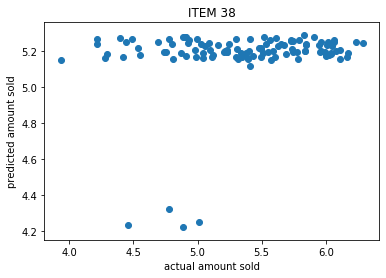

In [149]:
plt.scatter(y_38_test, y_38_test_predicted)
plt.title("ITEM 38")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

In [150]:
r2_score(y_38_test,y_38_test_predicted)

-0.10225755407413684

In [151]:
r2.append(r2_score(y_38_test,y_38_test_predicted))

In [152]:
rmse_38_test = np.sqrt(mean_squared_error(y_38_test, y_38_test_predicted))
rmse_test.append(rmse_38_test)
rmse_38_test

0.5671157618876256

* pogoršalo mi se, neću runnati dalje iteme

### 1.2 Item 39

In [70]:
X_39 = X.loc[39]

In [71]:
X_39.describe()

,regular_price,discounted_price,number_of_stores,amount
count,869.000000,869.000000,869.000000,869.000000
mean,0.099999,0.099999,458.894131,3445.628308
std,0.000034,0.000034,6.215435,1812.797700
min,0.099000,0.099000,423.000000,43.000000
25%,0.100000,0.100000,457.000000,2053.000000
50%,0.100000,0.100000,461.000000,3091.000000
75%,0.100000,0.100000,463.000000,4389.000000
max,0.100000,0.100000,467.000000,10120.000000


### Data preprocessing

In [63]:
X_39_train = pipeline.fit_transform(X_train)
X_39_test = pipeline.transform(X_test)

### Removing outliers

In [72]:
X_39 = removing_outliers(X_39)

In [73]:
X_39.describe()

,regular_price,discounted_price,number_of_stores,amount
count,781.0,781.0,781.000000,781.000000
mean,0.1,0.1,458.800256,3306.355954
std,0.0,0.0,6.366261,1392.684395
min,0.1,0.1,423.000000,1309.000000
25%,0.1,0.1,457.000000,2115.000000
50%,0.1,0.1,461.000000,3091.000000
75%,0.1,0.1,463.000000,4244.000000
max,0.1,0.1,467.000000,7389.000000


### Separating data into training and test set

In [74]:
X_39_train, X_39_test =  X_train_test_separation(X_39)
y_39_train, y_39_test =  y_train_test_separation(X_39)

In [75]:
print (X_39_train.shape, y_39_train.shape)
print (X_39_test.shape, y_39_test.shape)

(643, 3) (643,)
(138, 3) (138,)


### Scaling the Dataframe

In [76]:
for column in X_39_train:                               
    scaling_columns_seperately(X_39_train,X_39_test,column)

### Fitting the model on the data from training set

In [77]:
model_39 = lm.fit(X_39_train, y_39_train)

In [78]:
y_39_train_predicted = model_39.predict(X_39_train)

In [79]:
model_39.score(X_39_train, y_39_train)

0.011897137563180116

In [80]:
mae_39_train = mean_absolute_error(y_39_train, y_39_train_predicted)
mae_39_train

1145.0611624670885

In [81]:
mse_39_train = mean_squared_error(y_39_train, y_39_train_predicted)
mse_39_train

1922299.158910431

In [82]:
rmse_39_train = np.sqrt(mean_squared_error(y_39_train, y_39_train_predicted))
rmse_train.append(rmse_39_train)
rmse_39_train

1386.470035345312

### Fitting the model on the data from test set

In [83]:
y_39_test_predicted = model_39.predict(X_39_test)

In [84]:
mae_39_test = mean_absolute_error(y_39_test, y_39_test_predicted)
mae_39_test

1050.4567450755305

In [85]:
mse_39_test = mean_squared_error(y_39_test, y_39_test_predicted)
mse_39_test

1626007.5076877286

Text(0, 0.5, 'predicted amount sold')

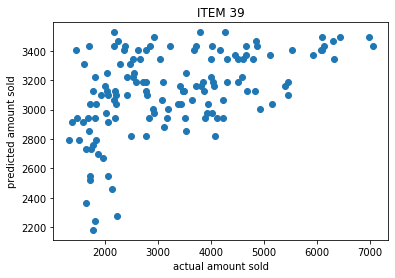

In [86]:
plt.scatter(y_39_test, y_39_test_predicted)
plt.title("ITEM 39")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

In [87]:
r2_score(y_39_test,y_39_test_predicted)

0.14333579082332026

In [58]:
r2.append(r2_score(y_39_test,y_39_test_predicted))

In [88]:
rmse_39_test = np.sqrt(mean_squared_error(y_39_test, y_39_test_predicted))
rmse_test.append(rmse_39_test)
rmse_39_test

1275.1499941919494

In [ ]:
#1026

### 1.3 Item 40

In [60]:
X_40 = X.loc[40]

In [61]:
X_40.describe()

,regular_price,discounted_price,number_of_stores,amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000
mean,0.763195,0.684793,315.353280,156.615650,0.143843,0.141542,0.144994,0.138090,0.143843,0.143843,0.143843
std,0.036849,0.120316,58.894878,115.959738,0.351133,0.348781,0.352298,0.345193,0.351133,0.351133,0.351133
min,0.539000,0.249000,212.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.769000,0.570000,268.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.769000,0.769000,304.000000,128.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.770000,0.769000,333.000000,190.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.771000,0.782000,450.000000,866.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data preprocessing

### Removing outliers

In [62]:
X_40 = removing_outliers(X_40)

In [63]:
X_40.describe()

,regular_price,discounted_price,number_of_stores,amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,0.765741,0.688190,315.725641,142.880769,0.143590,0.146154,0.148718,0.112821,0.144872,0.152564,0.151282
std,0.028273,0.120387,59.359604,73.175119,0.350898,0.353487,0.356039,0.316576,0.352197,0.359798,0.358554
min,0.539000,0.249000,213.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.769000,0.585750,268.000000,86.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.769000,0.769000,304.000000,128.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.770000,0.769000,334.000000,182.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.770000,0.782000,450.000000,396.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Separating data into training and test set

In [64]:
X_40_train, X_40_test =  X_train_test_separation(X_40)
y_40_train, y_40_test =  y_train_test_separation(X_40)

In [65]:
print (X_40_train.shape, y_40_train.shape)
print (X_40_test.shape, y_40_test.shape)

(644, 10) (644,)
(136, 10) (136,)


### Scaling the Dataframe

In [66]:
for column in X_40_train:                               
    scaling_columns_seperately(X_40_train,X_40_test,column)

### Fitting the model on the data from training set

In [67]:
model_40 = lm.fit(X_40_train, y_40_train)

In [68]:
y_40_train_predicted = model_40.predict(X_40_train)

In [69]:
model_40.score(X_40_train, y_40_train)

0.424065052723791

In [70]:
mae_40_train = mean_absolute_error(y_40_train, y_40_train_predicted)
mae_40_train

41.25839332527609

In [71]:
mse_40_train = mean_squared_error(y_40_train, y_40_train_predicted)
mse_40_train

3094.0198386897055

In [72]:
rmse_40_train = np.sqrt(mean_squared_error(y_40_train, y_40_train_predicted))
rmse_train.append(rmse_40_train)
rmse_40_train

55.62391426976086

### Fitting the model on the data from test set

In [73]:
y_40_test_predicted = model_40.predict(X_40_test)

In [74]:
mae_40_test = mean_absolute_error(y_40_test, y_40_test_predicted)
mae_40_test

40.47398562286282

In [75]:
mse_40_test = mean_squared_error(y_40_test, y_40_test_predicted)
mse_40_test

2895.948159406148

Text(0, 0.5, 'predicted amount sold')

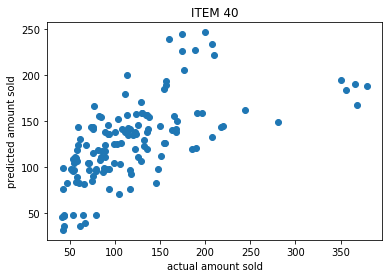

In [76]:
plt.scatter(y_40_test, y_40_test_predicted)
plt.title("ITEM 40")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

In [77]:
r2_score(y_40_test,y_40_test_predicted)

0.369771740005263

In [78]:
r2.append(r2_score(y_40_test,y_40_test_predicted))

In [79]:
rmse_40_test = np.sqrt(mean_squared_error(y_40_test, y_40_test_predicted))
rmse_test.append(rmse_40_test)
rmse_40_test

53.81401452601495

### 1.4 Item 41

In [80]:
X_41 = X.loc[41]

In [81]:
X_41.describe()

,regular_price,discounted_price,number_of_stores,amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000
mean,1.631242,1.619437,124.832757,29.512111,0.144175,0.141869,0.145329,0.137255,0.144175,0.143022,0.144175
std,0.000605,0.064786,29.843796,15.891616,0.351470,0.349117,0.352635,0.344315,0.351470,0.350297,0.351470
min,1.630000,1.078000,92.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.631000,1.631000,99.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.631000,1.631000,115.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.632000,1.632000,152.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.632000,1.705000,185.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data preprocessing

### Removing outliers

In [82]:
X_41 = removing_outliers(X_41)

In [83]:
X_41.describe()

,regular_price,discounted_price,number_of_stores,amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,1.631208,1.619985,124.498060,28.875809,0.148771,0.151358,0.156533,0.103493,0.125485,0.156533,0.157827
std,0.000591,0.062288,29.772698,12.273654,0.356093,0.358630,0.363595,0.304799,0.331483,0.363595,0.364814
min,1.630000,1.078000,92.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.631000,1.631000,99.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.631000,1.631000,115.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.632000,1.632000,152.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.632000,1.705000,185.000000,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Separating data into training and test set

In [84]:
X_41_train, X_41_test =  X_train_test_separation(X_41)
y_41_train, y_41_test =  y_train_test_separation(X_41)

In [85]:
print (X_41_train.shape, y_41_train.shape)
print (X_41_test.shape, y_41_test.shape)

(645, 10) (645,)
(128, 10) (128,)


### Scaling the Dataframe

In [86]:
for column in X_41_train:                               
    scaling_columns_seperately(X_41_train,X_41_test,column)

### Fitting the model on the data from training set

In [87]:
model_41 = lm.fit(X_41_train, y_41_train)

In [88]:
y_41_train_predicted = model_41.predict(X_41_train)

In [89]:
model_41.score(X_41_train, y_41_train)

0.47954878047862626

In [90]:
mae_41_train = mean_absolute_error(y_41_train, y_41_train_predicted)
mae_41_train

6.924228813298737

In [91]:
mse_41_train = mean_squared_error(y_41_train, y_41_train_predicted)
mse_41_train

77.30401169631011

In [92]:
rmse_41_train = np.sqrt(mean_squared_error(y_41_train, y_41_train_predicted))
rmse_train.append(rmse_41_train)
rmse_41_train

8.792269996781839

### Fitting the model on the data from test set

In [93]:
y_41_test_predicted = model_41.predict(X_41_test)

In [94]:
mae_41_test = mean_absolute_error(y_41_test, y_41_test_predicted)
mae_41_test

8.959824395759405

In [95]:
mse_41_test = mean_squared_error(y_41_test, y_41_test_predicted)
mse_41_test

113.12938318066699

Text(0, 0.5, 'predicted amount sold')

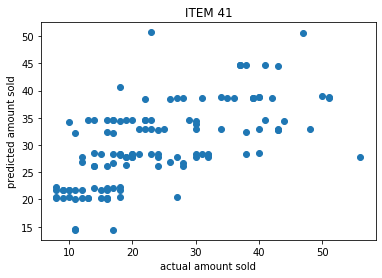

In [96]:
plt.scatter(y_41_test, y_41_test_predicted)
plt.title("ITEM 41")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

In [97]:
r2_score(y_41_test,y_41_test_predicted)

0.1585961041763292

In [98]:
r2.append(r2_score(y_41_test,y_41_test_predicted))

In [99]:
rmse_41_test = np.sqrt(mean_squared_error(y_41_test, y_41_test_predicted))
rmse_test.append(rmse_41_test)
rmse_41_test

10.636229744635408

### 1.5 Item 57

In [100]:
X_57 = X.loc[57]

In [101]:
X_57.describe()

,regular_price,discounted_price,number_of_stores,amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.080722,0.080722,87.906367,60.675406,0.149813,0.141074,0.138577,0.141074,0.149813,0.132335,0.147316
std,0.002036,0.002036,8.902105,44.194819,0.357111,0.348315,0.345720,0.348315,0.357111,0.339066,0.354642
min,0.079000,0.079000,70.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.080000,0.080000,81.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.080000,88.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.081000,0.081000,94.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.122000,0.122000,107.000000,372.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data preprocessing

### Handling outliers

In [102]:
X_57 = removing_outliers(X_57)

In [103]:
X_57.describe()

,regular_price,discounted_price,number_of_stores,amount,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.080541,0.080541,88.378151,55.789916,0.140056,0.138655,0.151261,0.134454,0.142857,0.141457,0.151261
std,0.000648,0.000648,8.799935,27.525291,0.347288,0.345829,0.358554,0.341378,0.350172,0.348736,0.358554
min,0.079000,0.079000,70.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.080000,0.080000,81.000000,34.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.080000,88.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.081000,0.081000,95.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.084000,0.084000,107.000000,141.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Separating data into training and test set

In [104]:
X_57_train, X_57_test =  X_train_test_separation(X_57)
y_57_train, y_57_test =  y_train_test_separation(X_57)

In [105]:
print (X_57_train.shape, y_57_train.shape)
print (X_57_test.shape, y_57_test.shape)

(617, 10) (617,)
(97, 10) (97,)


### Scaling the Dataframe

In [106]:
for column in X_57_train:                               
    scaling_columns_seperately(X_57_train,X_57_test,column)

### Fitting the model on the data from training set

In [107]:
model_57 = lm.fit(X_57_train, y_57_train)

In [108]:
y_57_train_predicted = model_57.predict(X_57_train)

In [109]:
model_57.score(X_57_train, y_57_train)

0.3399552264684853

In [110]:
mae_57_train = mean_absolute_error(y_57_train, y_57_train_predicted)
mae_57_train

17.264674353461643

In [111]:
mse_57_train = mean_squared_error(y_57_train, y_57_train_predicted)
mse_57_train

489.9520941516309

In [112]:
rmse_57_train = np.sqrt(mean_squared_error(y_57_train, y_57_train_predicted))
rmse_train.append(rmse_57_train)
rmse_57_train

22.134861511914433

### Fitting the model on the data from test set

In [113]:
y_57_test_predicted = model_57.predict(X_57_test)

In [114]:
mae_57_test = mean_absolute_error(y_57_test, y_57_test_predicted)
mae_57_test

19.439266230623232

In [115]:
mse_57_test = mean_squared_error(y_57_test, y_57_test_predicted)
mse_57_test

583.0183777410191

Text(0, 0.5, 'predicted amount sold')

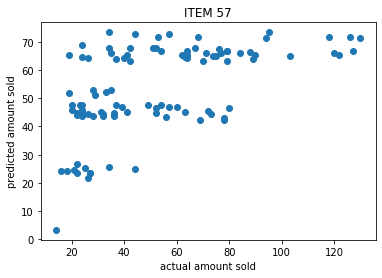

In [116]:
plt.scatter(y_57_test, y_57_test_predicted)
plt.title("ITEM 57")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

In [117]:
r2_score(y_57_test,y_57_test_predicted)

0.3022267306936127

In [118]:
r2.append(r2_score(y_57_test,y_57_test_predicted))

In [119]:
rmse_57_test = np.sqrt(mean_squared_error(y_57_test, y_57_test_predicted))
rmse_test.append(rmse_57_test)
rmse_57_test

24.145773496432437

In [120]:
rmse_train

[113.07483613523455,
 1208.443190963856,
 55.62391426976086,
 8.792269996781839,
 22.134861511914433]

In [121]:
rmse_test

[114.48763222584358,
 1026.3035238856492,
 53.81401452601495,
 10.636229744635408,
 24.145773496432437]

In [122]:
r2

[0.08183481921086233,
 0.44506806718154923,
 0.369771740005263,
 0.1585961041763292,
 0.3022267306936127]

In [123]:
for i in range(0,len(list_of_items)):
    print (list_of_items[i],": ", rmse_train[i])

38 :  113.07483613523455
39 :  1208.443190963856
40 :  55.62391426976086
41 :  8.792269996781839
57 :  22.134861511914433
